In [65]:
%run ../template.ipynb

In [66]:
exp_id = "050318"
series_names = ["greedy", "stems_cpp", "exhaustive"]
num_apps_range = range(2, 15+1)

In [67]:
setups = {}
for num_apps in num_apps_range:
    setups.update(dataloaders.load_setups(exp_id,
                                          setup_file_str="/setups.{exp_id}-" + str(num_apps) + "{version}.pickle",
                                          legacy='InconsistentIds'))
                                          

Loading setups... Using InconsistentIds... Done (100 loaded)
Loading setups... Using InconsistentIds... Done (100 loaded)
Loading setups... Using InconsistentIds... Done (100 loaded)
Loading setups... Using InconsistentIds... Done (100 loaded)
Loading setups... Using InconsistentIds... Done (100 loaded)
Loading setups... Using InconsistentIds... Done (100 loaded)
Loading setups... Using InconsistentIds... Done (100 loaded)
Loading setups... Using InconsistentIds... Done (100 loaded)
Loading setups... Using InconsistentIds... Done (100 loaded)
Loading setups... Using InconsistentIds... Done (0 loaded)
Loading setups... Using InconsistentIds... Done (0 loaded)
Loading setups... Using InconsistentIds... Done (0 loaded)
Loading setups... Using InconsistentIds... Done (0 loaded)
Loading setups... Using InconsistentIds... Done (100 loaded)


In [68]:
rows = []
# HACK
variants = {
    'greedy': 'v1+metrics',
    'exhaustive': 'v1+cost',
    'stems_cpp': None,
}
for series_name in series_names:
    if series_name == 'exhaustive':
        scheduleloader_kwargs = dict(apps_order='configurations')
    else:
        scheduleloader_kwargs = {}
    schedules = []
    for num_apps in num_apps_range:
        schedules += dataloaders.load_schedules("050318", series_name + ".mainstream.sim.*-" + str(num_apps) + ".v1", variant=variants[series_name], setups=setups, **scheduleloader_kwargs)
    rows += ex(schedules,
#                each=lambda s: {'f1': 1. - s.extra('metric'), 'fps': mean(s.fpses), 'num_apps': s.num_apps, 'budget': s.budget},
               each=lambda s: s.to_map({'setup_id': s.extra('setup_id')}),
               constant={'scheduler': series_name, 'sharing': 'mainstream'})
df = comb(rows)

In [69]:
def desc(self, verbose=2):
    if verbose == 0:
        return 'Schedule(f1={:g}, fpses={}, frozens={})'.format(self.mean_f1(), self.fpses, self.frozens)
    elif verbose == 2:
        return 'Schedule(f1={:g}, fpses={}, frozens={}, obj={})'.format(self.mean_f1(), self.fpses, self.frozens, self.objectives)

In [70]:
series_name = "exhaustive"
num_apps = 3
schedules = dataloaders.load_schedules("050318", series_name + ".mainstream.sim.150.*" + str(num_apps) + ".v1", variant=variants[series_name], setups=setups, apps_order='configurations')
print desc(schedules[0])

Schedule(f1=0.915013, fpses=[6, 4, 6], frozens=[33, 33, 33], obj=[0.0549195736761, 0.0314129414174, 0.168627364063])


In [71]:
series_name = "stems_cpp"
num_apps = 3
schedules2 = dataloaders.load_schedules("050318", series_name + ".mainstream.sim.150.*" + str(num_apps) + ".v1", variant=variants[series_name], setups=setups)
print desc(schedules2[0])

Schedule(f1=0.915013, fpses=[6, 6, 4], frozens=[33, 33, 33], obj=[0.0549195736761, 0.168627364063, 0.0314129414174])


In [72]:
df_view = df[df['budget'] == 150]
grouped = df_view.groupby(['scheduler', 'num_apps'])

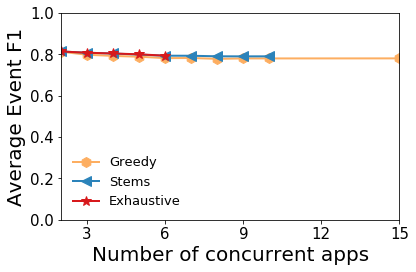

In [73]:
import matplotlib
matplotlib.rcParams.update({
    'axes.titlesize' : 24,
    'axes.labelsize': 20,
    'lines.linewidth': 3,
    'lines.markersize': 10,
    'xtick.labelsize': 15,
    'ytick.labelsize': 15,
    'legend.fontsize': 13,
})
series = agg2series(grouped['f1'].mean(),
                    names=series_names,
                    plotparams=dict(lw=2, markersize=10, linestyle='-', marker='.'))
ax = plot.variants(series, xgrid=grids.x.num_apps, ygrid=grids.y.f1)

In [81]:
df_view = df[df['sharing'] == 'mainstream']
df_sched = pd.pivot_table(df, index=['budget', 'num_apps', 'setup_id'], values='f1', columns='scheduler')
df_sched['exhaustive_stems_sanity'] = df_sched['exhaustive'] - df_sched['stems_cpp']
assert len(df_sched[df_sched['exhaustive_stems_sanity'] > 1e-5]) == 0

df_sched['greedy_loss_exhaustive'] = 1. - df_sched['greedy'] / df_sched['exhaustive']
df_sched['greedy_loss_stems'] = 1. - df_sched['greedy'] / df_sched['stems_cpp']

print df_sched['greedy_loss_exhaustive'].describe()
print
print df_sched['greedy_loss_stems'].describe()
df_sched[df_sched['greedy_loss_stems'] > .1]

count    2.400000e+03
mean     5.391113e-03
std      1.073095e-02
min     -4.440892e-16
25%      0.000000e+00
50%      3.901292e-05
75%      6.247293e-03
max      9.558758e-02
Name: greedy_loss_exhaustive, dtype: float64

count    4800.000000
mean        0.008880
std         0.012046
min        -0.000001
25%         0.000000
50%         0.004369
75%         0.012998
max         0.104919
Name: greedy_loss_stems, dtype: float64


scheduler                    exhaustive    greedy  stems_cpp  \
budget num_apps setup_id                                       
150.0  8        88b3781f.v1         NaN  0.664051   0.741890   
       9        1102dbef.v1         NaN  0.725342   0.806461   

scheduler                    exhaustive_stems_sanity  greedy_loss_exhaustive  \
budget num_apps setup_id                                                       
150.0  8        88b3781f.v1                      NaN                     NaN   
       9        1102dbef.v1                      NaN                     NaN   

scheduler                    greedy_loss_stems  
budget num_apps setup_id                        
150.0  8        88b3781f.v1           0.104919  
       9        1102dbef.v1           0.100586